## Project5: Vehicle Detection and Tracking
### Author: Paul Chun
### Last Update: 12/8/2017

### Library import

In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob
import time

# Gradient Function
from sklearn.cross_validation import train_test_split
from skimage.feature import hog

# Train Support Vector Classifier(SVC)
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC

# Heat Map
from scipy.ndimage.measurements import label

# Test Video
from moviepy.editor import VideoFileClip

/Users/paulchun/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 1. Image Processing Functions

In [2]:
'''
    This function returns an image with boxes drawn on where the objects(cars) are detected.
'''
def DrawBoxes(img, boxes, color = ( 0, 0, 255), thick = 6):
    # Make a copy of the image
    imgCopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for box in boxes:
        # Draw a rectangle given box coordinates
        # NOTE: box[0]: a top-left point of the box
        #       box[1]: a bottom-right point of the box
        cv2.rectangle(imgCopy, box[0], box[1], color, think)
    
    # Retrun the image copy with boxes drawn
    return imgCopy

'''
    This function returns color transformed image.
'''
def ConvertColorFromRGB(img, conv = 'YCrCb'):
    if conv != 'RGB':
        if conv == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif conv == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif conv == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif conv == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif conv == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif conv == 'Lab':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    else:
        return np.copy(img)
    

### 2. Feature Extraction functions

#### 1) Color Features

In [3]:
'''
    This function resize the image and returns a flatten(1-D) array.
'''
def BinSpatial(img, size = (32, 32)):
    # Create 1-D feature vector
    # NOTE: resize uses interpolation = cv2.INTER_LINEAR as default
    features = cv2.resize(img, size).ravel()
    return features

'''
    This function computes color histogram features.
    NOTE: NEED TO CHANGE binsRange if reading ".png" files with mpimg!
'''
def ColorHist(img, nBins = 32, binsRange = (0, 256)):
    # Compute the histogram of the color channels separately
    # NOTE: np.histogram returnes histogram features
    #       features = [array of # of pixels with binEdge value, array of # of bins ]
    histChannel1 = np.histogram( img[:,:,0], bins = nBins, range = binsRange)
    histChannel2 = np.histogram( img[:,:,1], bins = nBins, range = binsRange)
    histChannel3 = np.histogram( img[:,:,2], bins = nBins, range = binsRange)
    
    # Concatenate the histograms into a single feature vector
    histFeatures = np.concatenate((histChannel1[0], histChannel2[0], histChannel3[0]))
    return histFeatures

#### 2) Gradient Features

In [4]:
'''
    This function returns the features of HOG and HOG image(optional).
'''
def GetHogFeatures(img, orient, pixPerCell, cellPerBlock, vis = False, featureVec = True):
    # Return feature, hog image if vis == True
    if vis == True:
        features, hogImage = hog(img, orientations = orient, pixels_per_cell=(pixPerCell, pixPerCell),
                                cells_per_block=(cellPerBlock, cellPerBlock), transform_sqrt=False,
                                visualise = vis, feature_vector = featureVec)
        return features, hogImage
    else:
        features = hog(img, orientations = orient, pixels_per_cell=(pixPerCell, pixPerCell),
                                cells_per_block=(cellPerBlock, cellPerBlock), transform_sqrt=False,
                                visualise = vis, feature_vector = featureVec)
        return features

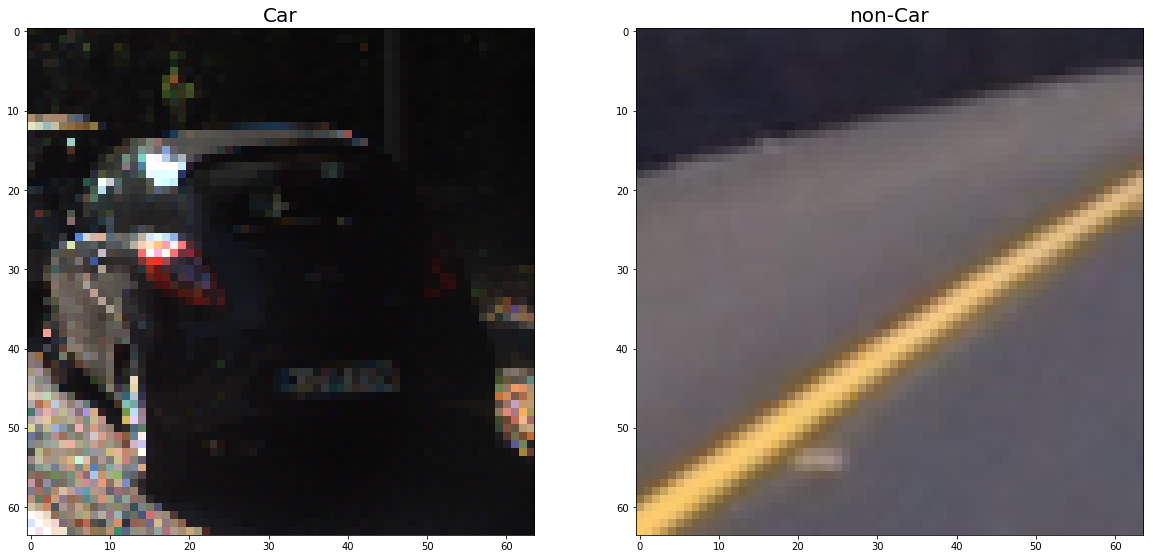

In [68]:
carImageNames = glob.glob('./vehicles/KITTI_extracted/*.png') \
                +glob.glob('./vehicles/GTI_Left/*.png')    \
                +glob.glob('./vehicles/GTI_Far/*.png') \
                +glob.glob('./vehicles/GTI_MiddleClose/*.png') \
                +glob.glob('./vehicles/GTI_Right/*.png')


nonCarImageNames = glob.glob('./non-vehicles/Extras/*.png') \
                   +glob.glob('./non-vehicles/GTI/*.png')
    
colorSpace = 'Lab'
orient = 9
pixPerCell = 8
cellPerBlock = 2
hogChannel = 'ALL'
spatialSize = (32, 32)
histBins = 8
spatialFeat = True
histFeat = True
hogFeat = True

carImg = mpimg.imread(carImageNames[0])
nonCarImg = mpimg.imread(nonCarImageNames[1])

fig = plt.figure(figsize=(20,15))
plt.subplot(121)
plt.imshow(carImg)
plt.title('Car', fontsize=20)
plt.subplot(122)
plt.imshow(nonCarImg)
plt.title('non-Car', fontsize=20)

plt.show()

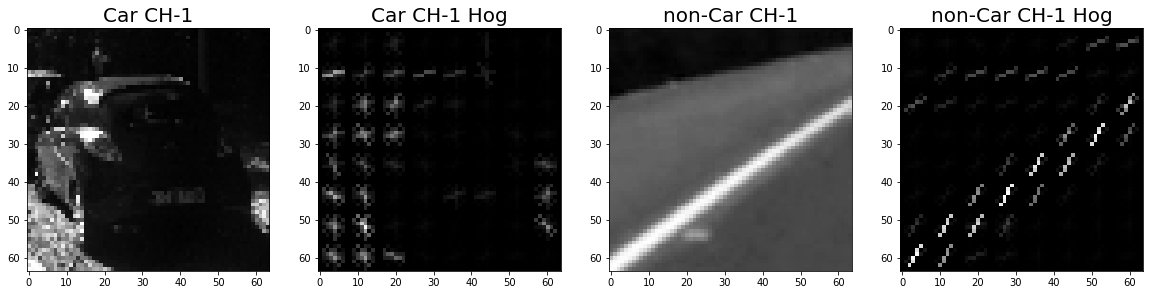

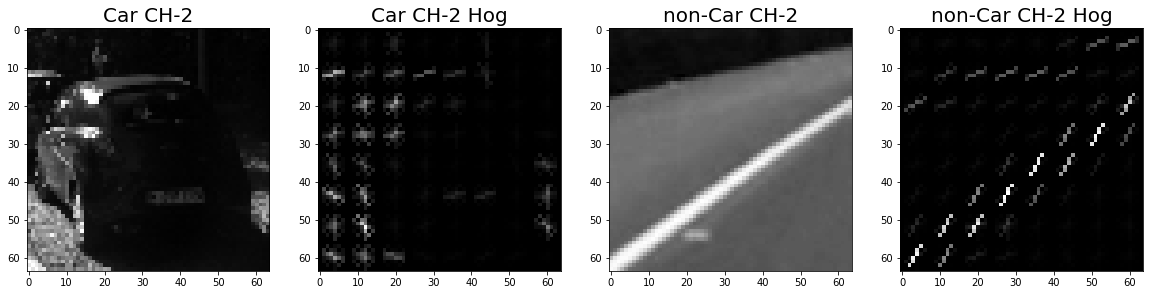

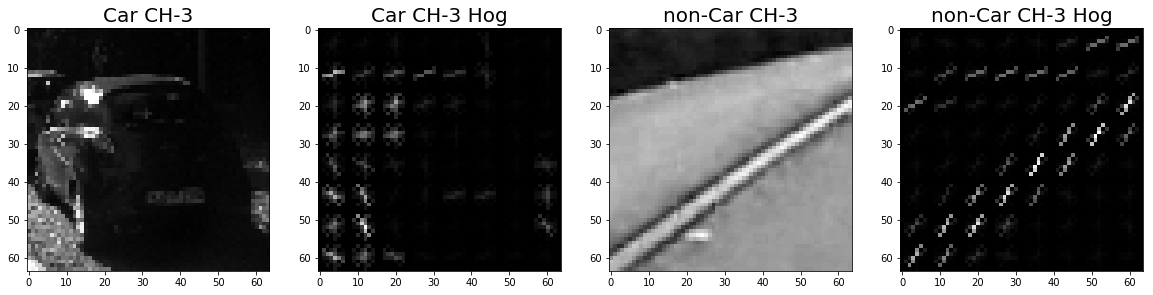

In [69]:

for i in range(0,3):
    carFeatures, hogCarImg = GetHogFeatures(carImg[:,:,i], orient, pixPerCell, cellPerBlock, vis = True, featureVec = True)
    nonCarFeatures, hogNonCarImg = GetHogFeatures(nonCarImg[:,:,i], orient, pixPerCell, cellPerBlock, vis = True, featureVec = True)
    
    fig = plt.figure(figsize=(20,15))
    plt.subplot(141)
    plt.imshow(carImg[:,:,i],cmap ='gray')
    plt.title('Car CH-{}'.format(i+1), fontsize=20)
    plt.subplot(142)
    plt.imshow(hogCarImg, cmap ='gray')
    plt.title('Car CH-{} Hog'.format(i+1), fontsize=20)
    
    plt.subplot(143)
    plt.imshow(nonCarImg[:,:,i],cmap ='gray')
    plt.title('non-Car CH-{}'.format(i+1), fontsize=20)
    plt.subplot(144)
    plt.imshow(hogNonCarImg, cmap ='gray')
    plt.title('non-Car CH-{} Hog'.format(i+1), fontsize=20)


plt.show()


### 3. Training Support Vector Classifier

#### 1) Extract Feature Pipeline Function

In [5]:
def ExtractFeaturesPipeline( imgNames, colorSpace = 'YCrCb', spatialSize = (32, 32),
                        histBins = 32, orient = 9, pixPerCell = 8, cellPerBlock = 2,
                        hogChannel = 0, spatialFeat = True, histFeat = True, 
                        hogFeat = True):
    # Feature list
    features = []
    
    for imgName in imgNames:
        fileFeatures = []
        img = mpimg.imread(imgName)
        
        featureImage = ConvertColorFromRGB(img, colorSpace)
        
        if spatialFeat == True:
            spatialFeatures = BinSpatial(featureImage, size=spatialSize)
            fileFeatures.append(spatialFeatures)
            
        if histFeat == True:
            histFeatures = ColorHist(featureImage, nBins=histBins)
            fileFeatures.append(histFeatures)
            
        if hogFeat == True:
            if hogChannel == 'ALL':
                hogFeatures = []
                for channel in range(featureImage.shape[2]):
                    hogFeatures.extend(GetHogFeatures(featureImage[:,:,channel],
                                                     orient, pixPerCell, cellPerBlock,
                                                     vis = False, featureVec = True))
            else:
                hogFeatures = GetHogFeatures( featureImage[:,:,hogChannel], orient,
                                           pixPerCell, cellPerBlock, vis=False, featureVec = True)
            fileFeatures.append(hogFeatures)
            
        features.append(np.concatenate(fileFeatures))
    return features

#### 2) Run The Extraction Pipeline

In [6]:
tStart = time.time()
carFeatures = ExtractFeaturesPipeline(carImageNames, colorSpace=colorSpace, spatialSize=spatialSize,
                        histBins=histBins, orient=orient, 
                        pixPerCell=pixPerCell, cellPerBlock=cellPerBlock, hogChannel=hogChannel,
                        spatialFeat=spatialFeat, histFeat=histFeat, hogFeat=hogFeat)
nonCarFeatures = ExtractFeaturesPipeline(nonCarImageNames, colorSpace=colorSpace, spatialSize=spatialSize,
                        histBins=histBins, orient=orient, 
                        pixPerCell=pixPerCell, cellPerBlock=cellPerBlock, hogChannel=hogChannel,
                        spatialFeat=spatialFeat, histFeat=histFeat, hogFeat=hogFeat)
tEnd = time.time()


# Display the time taken for extraction
print( round(tEnd - tStart,2), 'seconds to extract HOG features...') #spatial, histogram, HOG


94.14 seconds to extract HOG features...


#### 3) Train And Test Linear Support Vector Classifier(SVC)

In [7]:
# Define feature vector
featureVector = np.vstack((carFeatures, nonCarFeatures)).astype(np.float64)

# Fit a per-column scaler
featureVectorScaler = StandardScaler().fit(featureVector)


# Apply the scaler to 'featureVector'
sFeatureVector = featureVectorScaler.transform(featureVector)


# Define the label vector
labelVector = np.hstack((np.ones(len(carFeatures)), np.zeros(len(nonCarFeatures))))

# Split up data into randomized training and test sets
randomState = np.random.randint(0, 100)
featureTrain, featureTest, labelTrain, labelTest = train_test_split(sFeatureVector, labelVector, test_size=0.2, random_state = randomState)


print('Using:', orient,'orientations', pixPerCell, 'pixels per cell and', cellPerBlock,'cells per block')
print('Feature vector length:', len(featureTrain[0]))

svc = LinearSVC()
tStart = time.time()
svc.fit(featureTrain, labelTrain)
tEnd = time.time()
print(round(tEnd-tStart, 2), 'Seconds to train SVC...')

print('Test Accuracy of SVC = ', round(svc.score(featureTest, labelTest), 4))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8388
26.05 Seconds to train SVC...
Test Accuracy of SVC =  0.9859


### 4. Vehicle Detection

#### 1) Pipeline

In [80]:
def DetectVehicle(img, yStart, yStop, scale, classifier, 
                  featureVectorScaler, orient, pixPerCell, 
                  cellPerBlock, spatialSize, histBins ):
    drawImg = np.copy(img)
    drawWindImg = np.copy(drawImg)
    
    img = img.astype(np.float32)/255
    boxList = []
    
    for scale in scales:
        imgToSearch = img[yStart:yStop, :, :]
        cConvImgToSearch = ConvertColorFromRGB(imgToSearch, conv = 'Lab')
        
        if scale != 1:
            imgShape = cConvImgToSearch.shape
            cConvImgToSearch = cv2.resize(cConvImgToSearch, (np.int(imgShape[1]/scale), np.int(imgShape[0]/scale)))
        
        ch1 = cConvImgToSearch[:,:,0]
        ch2 = cConvImgToSearch[:,:,1]
        ch3 = cConvImgToSearch[:,:,2]
        
        nxBlocks = (ch1.shape[1] // pixPerCell) - cellPerBlock + 1
        nyBlocks = (ch1.shape[0] // pixPerCell) - cellPerBlock + 1
        nFeatPerBlock = orient * cellPerBlock**2

        window = 64
        nBlocksPerWindow = (window//pixPerCell) - cellPerBlock + 1
        cellsPerStep = 2
        nxSteps = (nxBlocks - nBlocksPerWindow) // cellsPerStep
        nySteps = (nyBlocks - nBlocksPerWindow) // cellsPerStep

        hog1 = GetHogFeatures(ch1, orient, pixPerCell, cellPerBlock, featureVec = False)
        hog2 = GetHogFeatures(ch2, orient, pixPerCell, cellPerBlock, featureVec = False)
        hog3 = GetHogFeatures(ch3, orient, pixPerCell, cellPerBlock, featureVec = False)
        count = 0;
        for xb in range(nxSteps):
            for yb in range(nySteps):
                yPos = yb * cellsPerStep
                xPos = xb * cellsPerStep
                #print(yPos, yPos+ nBlocksPerWindow, xPos, xPos + nBlocksPerWindow)
                hogFeat1 = hog1[yPos: yPos+ nBlocksPerWindow, xPos: xPos + nBlocksPerWindow].ravel()
                hogFeat2 = hog2[yPos: yPos+ nBlocksPerWindow, xPos: xPos + nBlocksPerWindow].ravel()
                hogFeat3 = hog3[yPos: yPos+ nBlocksPerWindow, xPos: xPos + nBlocksPerWindow].ravel()
                hogFeatures = np.hstack((hogFeat1, hogFeat2, hogFeat3))
                #hogFeatures = hogFeat1
                #print(hogFeat1.shape)
                xLeft = xPos * pixPerCell
                yTop = yPos * pixPerCell

                subImg = cv2.resize(cConvImgToSearch[yTop:yTop + window, xLeft:xLeft + window], (64, 64))
                spatialFeatures = BinSpatial(subImg, size = spatialSize)
                #print(spatialFeatures.shape)

                histFeatures = ColorHist(subImg, nBins = histBins)
                #print(histFeatures.shape)

                testFeatures = featureVectorScaler.transform(np.hstack((spatialFeatures, histFeatures, hogFeatures)).reshape(1, -1))

                testPrediction = classifier.predict(testFeatures)

                xBoxLeft = np.int(xLeft * scale)
                yTopDraw = np.int(yTop * scale)
                winDraw = np.int(window * scale)
                if((count%2) == 0):
                    color = (0, 0, 255)
                else:
                    color = (255,0, 0)
                    
                
                cv2.rectangle(drawWindImg, (xBoxLeft, yTopDraw + yStart), (xBoxLeft + winDraw, yTopDraw + winDraw + yStart),color, 6)
                if testPrediction == 1:
                    xBoxLeft = np.int(xLeft * scale)
                    yTopDraw = np.int(yTop * scale)
                    winDraw = np.int(window * scale)
                    boxList.append([(xBoxLeft, yTopDraw + yStart), (xBoxLeft + winDraw, yTopDraw + winDraw + yStart)])
                    #print((xBoxLeft, yTopDraw + yStart), (xBoxLeft + winDraw, yTopDraw + winDraw + yStart))
                    cv2.rectangle(drawImg, (xBoxLeft, yTopDraw + yStart), (xBoxLeft + winDraw, yTopDraw + winDraw + yStart),(0, 0, 255), 6)

    return boxList, drawImg, drawWindImg



#### 2) Heat Maps

In [81]:
def AddHeat(heatMap, boxes):
    for box in boxes:
        heatMap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    return heatMap

def ApplyThreshold(heatMap, threshold):
    heatMap[heatMap <= threshold] = 0
    return heatMap

def DrawLabeledBoxes(img, labels):
    if labels[1] > 0:
        for carNumber in range(1, labels[1]+1):    
            nonzero = (labels[0] == carNumber).nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            box = ((np.min(nonzerox), np.min(nonzeroy)),(np.max(nonzerox),np.max(nonzeroy)))
            cv2.rectangle(img, box[0], box[1], (0,0,255), 6) 
        return img, box
    
    return img, None

### Main function

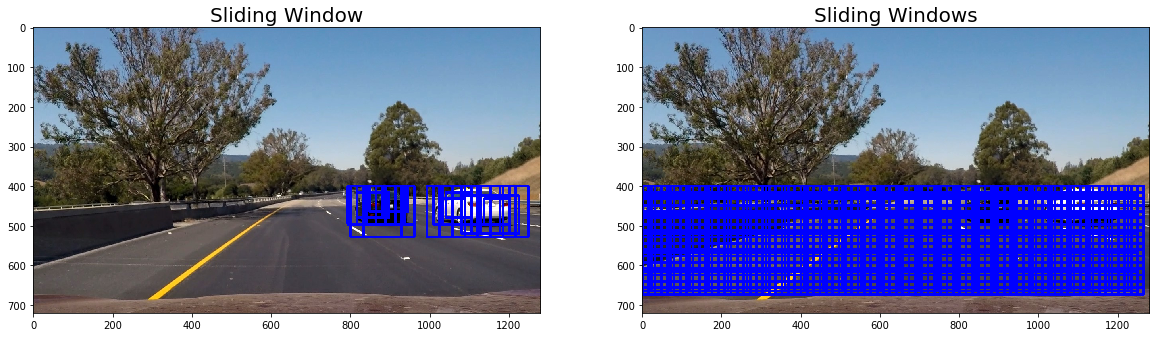

In [83]:
'''
     NOTE: An image is read in BGR mode by openCV library function.
'''

imgName = glob.glob("./test_images/*.jpg")

img = cv2.imread(imgName[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

yStart = 400
yStop = 700

#scales = np.arange(1.2, 1.3, 0.1)
#scales = np.array([1.0, 1.2, 1.4, 1.7, 2.2])
scales = np.array([1.0, 1.5, 2.0])

classifier = svc

orient = 9

boxList,output, rawOutput = DetectVehicle(img, yStart, yStop, scales, classifier, 
                  featureVectorScaler, orient, pixPerCell, 
                  cellPerBlock, spatialSize, histBins )

fig = plt.figure(figsize=(20,15))
plt.subplot(121)
plt.imshow(output)
plt.title('Sliding Window', fontsize=20)
plt.subplot(122)
plt.imshow(rawOutput)
plt.title('Sliding Windows', fontsize=20)
plt.show()

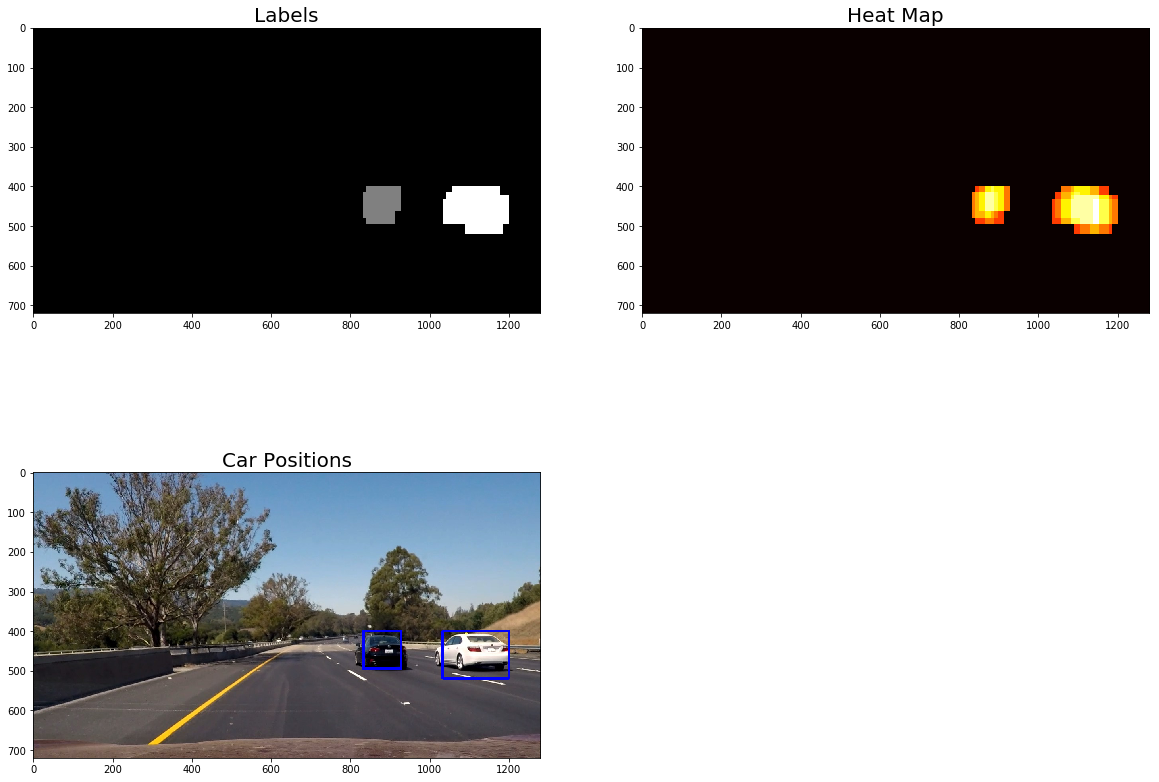

In [118]:
import collections

heatmaps = collections.deque(maxlen=20)

heat = np.zeros_like(img[:,:,0]).astype(np.float)

heat = AddHeat(heat, boxList)
heat = ApplyThreshold(heat, 4)
heatmaps.append(heat)

heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
drawImg, box = DrawLabeledBoxes(np.copy(img), labels)

fig = plt.figure(figsize=(20,15))
plt.subplot(221)
plt.imshow(labels[0], cmap = 'gray')
plt.title('Labels', fontsize=20)
plt.subplot(222)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map', fontsize=20)
plt.subplot(223)
plt.imshow(drawImg)
plt.title('Car Positions', fontsize=20)


plt.show()


### Process each frame of a video

In [43]:
def processFrame(frame):
    img = np.copy(frame)
    
    yStart = 400
    yStop = 700

    #scales = np.arange(1.2, 1.3, 0.1)
    #scales = np.array([1.0, 1.2, 1.4, 1.7, 2.2])
    scales = np.array([1.0, 1.5, 2.0])
    classifier = svc

    orient = 9

    boxList,output = DetectVehicle(img, yStart, yStop, scales, classifier, 
                      featureVectorScaler, orient, pixPerCell, 
                      cellPerBlock, spatialSize, histBins )
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    heat = AddHeat(heat, boxList)
    heatmaps.append(heat)
    sumHeatmap = sum(heatmaps)
    
    heat = ApplyThreshold(sumHeatmap, 25)

    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    drawImg, box = DrawLabeledBoxes(np.copy(img), labels)
        
    output = drawImg
    
    return output

### Test Video

In [44]:
videoOutput1 = 'test_video_output.mp4'
videoInput1 = VideoFileClip('test_video.mp4')
processedVideo = videoInput1.fl_image(processFrame)
%time processedVideo.write_videofile(videoOutput1,audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [01:02<00:01,  1.65s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 1min 4s, sys: 1.59 s, total: 1min 5s
Wall time: 1min 2s


In [45]:
videoOutput1 = 'project_video_output.mp4'
videoInput1 = VideoFileClip('project_video.mp4')
processedVideo = videoInput1.fl_image(processFrame)
%time processedVideo.write_videofile(videoOutput1,audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [33:25<00:01,  1.63s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 34min 37s, sys: 47.8 s, total: 35min 25s
Wall time: 33min 26s
